# Frame preprocessing
To prepaire the data for VideoVAE training
Due the big size of image dataset, I'm providing the dataset prepaired in .npy file

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import os
import cv2
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

In [ ]:
origin_df_csv = '/content/drive/MyDrive/Herts - BSc /3rd Year/FYP/full_standardized.csv'
df_origin = pd.read_csv(origin_df_csv, index_col = 0)

In [ ]:
df_origin

,frame_name,Subject,Activity,Trial,full_path,frame_name_standardized,Timestamp,Tag,Fall
0,2018-07-04T12_04_17.738369,1,1,1,/content/drive/MyDrive/Fall-Detection/UP-Fall-...,2018-07-04 12:04:17.738369,2018-07-04 12:04:17.738369,7,0
1,2018-07-04T12_04_17.790509,1,1,1,/content/drive/MyDrive/Fall-Detection/UP-Fall-...,2018-07-04 12:04:17.790509,2018-07-04 12:04:17.738369,7,0
2,2018-07-04T12_04_17.836632,1,1,1,/content/drive/MyDrive/Fall-Detection/UP-Fall-...,2018-07-04 12:04:17.836632,2018-07-04 12:04:17.738369,7,0
3,2018-07-04T12_04_17.885262,1,1,1,/content/drive/MyDrive/Fall-Detection/UP-Fall-...,2018-07-04 12:04:17.885262,2018-07-04 12:04:17.738369,7,0
4,2018-07-04T12_04_17.945423,1,1,1,/content/drive/MyDrive/Fall-Detection/UP-Fall-...,2018-07-04 12:04:17.945423,2018-07-04 12:04:17.738369,7,0
...,...,...,...,...,...,...,...,...,...
246348,2018-07-12T12_00_18.980263,17,5,3,/content/drive/MyDrive/Fall-Detection/UP-Fall-...,2018-07-12 12:00:18.980263,2018-07-12 12:00:17.775836,11,0
246349,2018-07-12T12_00_19.026386,17,5,3,/content/drive/MyDrive/Fall-Detection/UP-Fall-...,2018-07-12 12:00:19.026386,2018-07-12 12:00:17.775836,11,0
246350,2018-07-12T12_00_19.076520,17,5,3,/content/drive/MyDrive/Fall-Detection/UP-Fall-...,2018-07-12 12:00:19.076520,2018-07-12 12:00:17.775836,11,0
246351,2018-07-12T12_00_19.125150,17,5,3,/content/drive/MyDrive/Fall-Detection/UP-Fall-...,2018-07-12 12:00:19.125150,2018-07-12 12:00:17.775836,11,0


In [ ]:
import re

def extract_activity(full_path):
    match = re.search(r'Activity(\d+)', full_path)
    if match:
        return int(match.group(1))
    return None

# Extract the activity number
df_origin['extracted_activity'] = df_origin['full_path'].apply(extract_activity)

# Filter rows where Tag is less than 6 == Fall events
fall_mask = df_origin['Tag'] < 6

# Check if the extracted activity is also < 6 for these rows
incorrect_rows = df_origin[fall_mask & (df_origin['extracted_activity'] >= 6)]

if incorrect_rows.empty:
    print("All rows with Tag < 6 have an Activity number < 6")
else:
    print("Some rows with Tag < 6 have an Activity number > 6")


True: All rows with Tag < 6 have an Activity number < 6


In [ ]:
def load_and_preprocess_image(img_path, target_size=(128, 128)):
    """
    Passing the img path, which is loaded then, converts it to RGB, resizes it, and normalises pixel values.

    Parameters:
    - img_path (str): Full path to the image file.
    - target_size: (width, height) for resizing.

    Returns:
    - np.array: Preprocessed image with shape (height, width, channels) (128, 128, 3).
    """
    # Load the image
    image_bgr = cv2.imread(img_path)

    # Convert from BGR to RGB
    image_rgb = cv2.cvtColor(image_bgr, cv2.COLOR_BGR2RGB)

    # Resize to target dimensions
    image_resized = cv2.resize(image_rgb, target_size)

    # Normalize pixel values to [0, 1]
    image_normalized = image_resized.astype(np.float32) / 255.0

    return image_normalized


In [ ]:
import numpy as np
import concurrent.futures
from tqdm import tqdm

def prepare_data_for_vae(
    camera_dict,
    sequence_length=9,
    target_size=(128, 128),
    log_interval=10
):
    """
    Prepares frames/sequences for a VAE.

    Parameters:
    camera_dict: {timestamp: [frame_dicts]}
    sequence_length: Number of frames in each sequence (if is_video=True).
    target_size: Desired (width, height) for resizing.
    log_interval: Print progress every N timestamps.

    Returns:
    np.array: shape (num_sequences, sequence_length, H, W, C)
    """
    print("======================================")
    print("Preparing data for VAE...")
    print(f"  - is_video: {is_video}")
    print(f"  - target_size: {target_size[0]}x{target_size[1]}")
    print(f"  - sequence_length: {sequence_length}")
    print(f"  - Timestamps found: {len(camera_dict)}")
    print("======================================")
    # schedule tasks for each frame in every sequence.
    sequences = []
    future_dict = {}  # (sequence_index, frame_index)

    with concurrent.futures.ThreadPoolExecutor() as executor:
        for seq_idx, (timestamp, frames_info) in enumerate(camera_dict.items(), start=1):
            if seq_idx % log_interval == 0:
                print(f"  [Video-sequence] Processed {seq_idx}/{len(camera_dict)} timestamps..")

            # Sort frames by time
            sorted_frames = sort_frames_by_time(frames_info)
            frame_paths = [f['full_path'] for f in sorted_frames]

            # Pad or truncate to exactly sequence_length
            if len(frame_paths) < sequence_length:
                pad_needed = sequence_length - len(frame_paths)
                frame_paths += [frame_paths[-1]] * pad_needed
            else:
                frame_paths = frame_paths[:sequence_length]

            # Submit a task for each frame in this sequence.
            for frame_idx, path in enumerate(frame_paths):
                future = executor.submit(load_and_preprocess_image, path, target_size=target_size)
                future_dict[(seq_idx, frame_idx)] = future

        # Total number of frame tasks.
        total_tasks = len(camera_dict) * sequence_length
        # Create a progress bar.
        pbar = tqdm(total=total_tasks, desc="Loading images")

        # sequences in order.
        for seq_idx in range(1, len(camera_dict) + 1):
            frame_results = []
            for frame_idx in range(sequence_length):
                # This will block until the task is complete.
                frame_results.append(future_dict[(seq_idx, frame_idx)].result())
                pbar.update(1)
            frames_array = np.stack(frame_results, axis=0)  # shape: (sequence_length, H, W, C)
            sequences.append(frames_array)

        pbar.close()

    data_array = np.array(sequences)  # shape: (num_sequences, sequence_length, H, W, C)

    print("--------------------------------------")
    print("Video-sequence data preparation complete.")
    print(f"  Total sequences: {len(sequences)}")
    print(f"  Final shape: {data_array.shape}")
    print("--------------------------------------")

    return data_array



In [ ]:
if __name__ == "__main__":
    video_data = prepare_data_for_vae(
        camera_dict=fall_activity_data_dict,
        sequence_length=9,
        target_size=(128, 128),
        is_video=True,
        log_interval=50
    )

Preparing data for VAE...
  - target_size: 128x128
  - Timestamps found: 4588


Processing Timestamps: 100%|██████████| 4588/4588 [1:57:01<00:00,  1.53s/it]


--------------------------------------
Video-sequence data preparation complete.
  Total sequences: 4588
  Final shape: (4588, 9, 128, 128, 3)
--------------------------------------


In [ ]:
save_path = '/content/drive/MyDrive/Herts - BSc /3rd Year/FYP/processed_data/video_data-9frame-v_X_.0.npy'
np.save(save_path, video_data)

# Let's try to visualise and see what we just creacted

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation

npy_path = '/content/drive/MyDrive/Herts - BSc /3rd Year/FYP/processed_data/video_data-9frame-v1.0.npy'
data = np.load(npy_path, allow_pickle=True)

print("Shape of the array:", data.shape)
# Should be (632, 9, 128, 128, 3)

Shape of the array: (632, 9, 128, 128, 3)


# Few Visual Checks

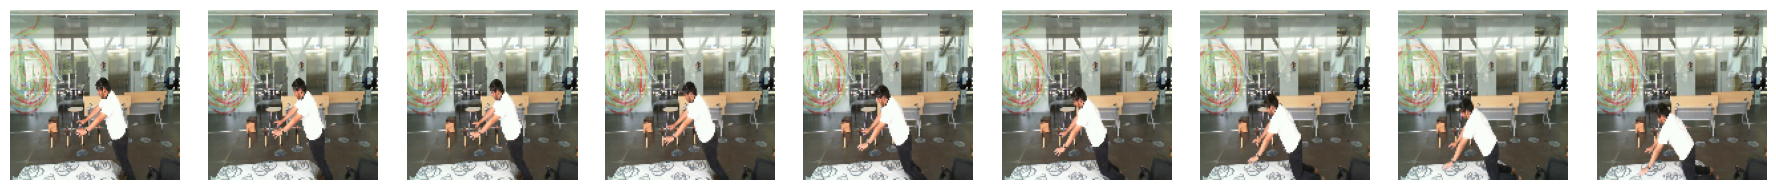

In [ ]:
sample = data[2]
num_of_frames = sample.shape[0]

fig, axes = plt.subplots(1, num_of_frames, figsize=(num_of_frames * 2, 2))

for i in range(num_of_frames):
    frame = sample[i]
    axes[i].imshow(frame)
    axes[i].axis('off')
plt.tight_layout()
plt.show()

Because data is normalised, the expected minimum 0 and maximum 1

In [ ]:
print("Data Type:", data.dtype)
print("Minimum Pixel Value:", data.min())
print("Maximum Pixel Value:", data.max())

Data Type: float32
Minimum Pixel Value: 0.0
Maximum Pixel Value: 1.0


**Lets select a single chunk (9 frames), from our whole npy file**

In [ ]:
sample_index = 3
sample = data[sample_index]

print(f"Selected Sample Index: {sample_index}")
print(f"Sample Shape: {sample.shape}")

Selected Sample Index: 3
Sample Shape: (9, 128, 128, 3)


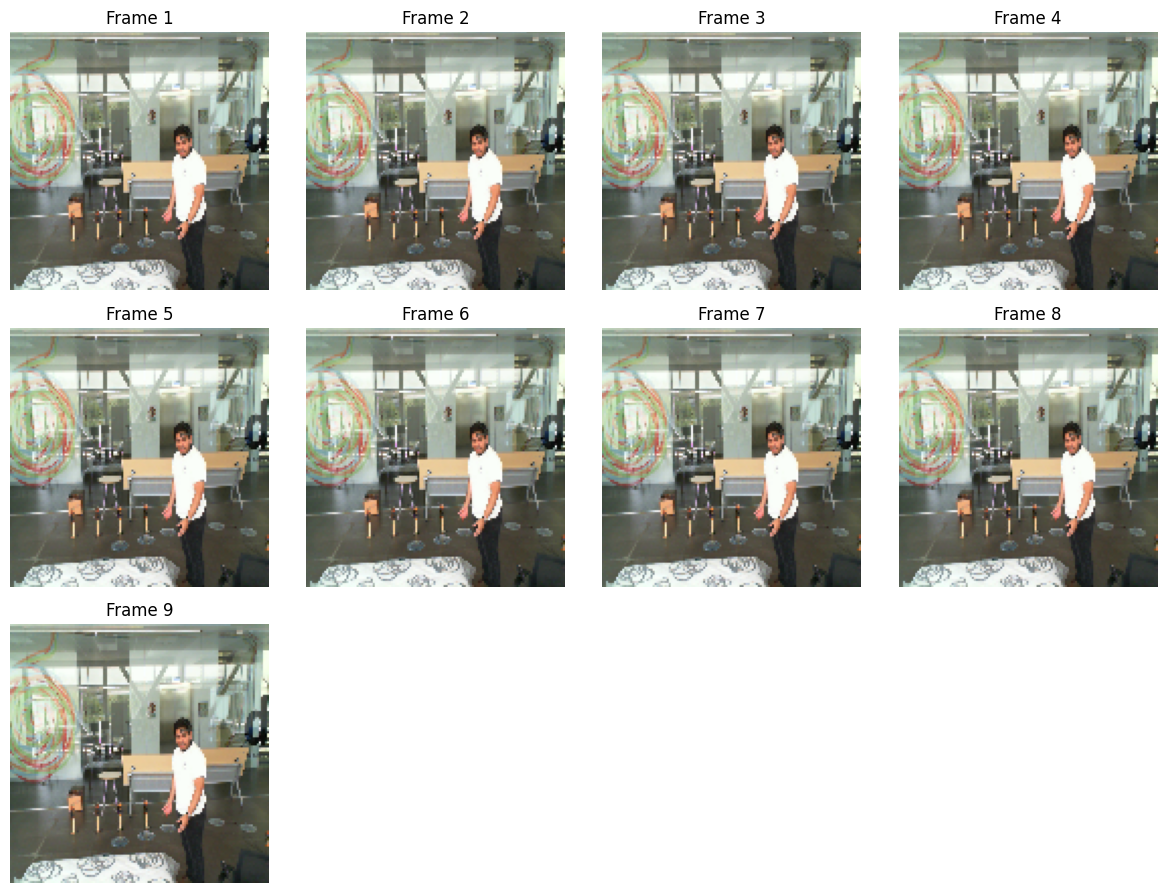

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

sample_index = 1
frame_index = 0
frame = data[sample_index, frame_index]

frame_scaled = (frame * 255).astype(np.uint8)

num_frames = sample.shape[0]

plt.figure(figsize=(12,12))
rows=4
cols=4

for i in range(num_frames):
    frame = sample[i]

    if np.issubdtype(frame.dtype, np.floating):
        if frame.max() <= 1.0:
            frame_scaled = (frame * 255).astype(np.uint8)
        else:
            frame_scaled = frame
    else:
        frame_scaled = frame

    plt.subplot(rows, cols, i + 1)
    plt.imshow(frame_scaled)
    plt.title(f"Frame {i+1}")
    plt.axis('off')

plt.tight_layout()
plt.show()